<a href="https://colab.research.google.com/github/JorgeLLF/FSI/blob/main/RedInsectosImageDataGenerator1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Reconocedor de insectos**

Vamos a desarrollar una red que reconozca insectos. Para ello, vamos a utilizar un dataset contenido en mi cuenta de Google Drive. 

Contaremos con **5 clases** diferenciadas, entre las cuales hay **abejas, arácnidos, hormigas, libélulas y saltamontes**.

El dataset de entrenamiento está formada por 200 imágenes repartidas uniformemente entre las 5 clases, y el dataset de validación por 50 repartidas de igual manera.



In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Debemos acordarnos de utilizar la GPU, en **Editar / Configuración del cuaderno o Entorno de ejecución / Cambiar tipo de entorno de ejecución**

In [20]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Veamos una imagen de ejemplo.

'Resized ImageDataGenerator'  'Resized NoImageDataGenerator'


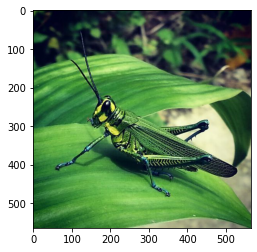

In [21]:
from skimage import io
import os

!ls "/content/drive/My Drive/Colab Notebooks/datasets/"

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/Resized ImageDataGenerator/Training/Saltamontes/Saltamontes34.jpg', 'r')
imshow(np.asarray(pil_im))

# *Parametrización y creación de los DataGenerator*

El principal problema que tiene nuestro dataset es que tiene relativamente pocas imágenes. Hay una forma de generar muchas más imágenes a partir de las que ya tenemos, y es el **Data Augmentation**.

Por ejemplo, en nuestro caso le estaremos diciendo al generador de datos de entrenamiento que coja las imágenes del conjunto de entrenamiento y genere otras imágenes rotando las originales en un rango de +-15º y haciendo un zoom de +-10%.

In [22]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        zoom_range=0.1,
)

validation_datagen = ImageDataGenerator(
        rescale=1./255,
)

# *Parametrización y ubicación de las fuentes de datos*

A continuación, indicamos el tamaño que queremos que tengan las imágenes, ya que, en la fuente de datos original, no todas son iguales.

Por otro lado, indicaremos el tamaño del batch/lote a ser usado a la hora de procesar imágenes de ambos conjuntos, tanto de entrenamiento como de validación.

Indicamos que el class_mode es "categorical" porque tenemos más de 2 clases

Por último, y muy importante, el parámetro **shuffle debe ser False**, ya que de no indicar nada será True, y eso nos perjudicará a la larga. Lo que queremos es que el procesado de imágenes del dataset de validación se haga en el mismo orden. De no ser así, a la hora de hacer la matriz de confusión no nos mostrará los datos en el orden correcto.

In [23]:
# Fuente de datos --------------------------------------------------
from keras.preprocessing.image import ImageDataGenerator

image_size = (150, 150)
batch_size = 10

train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/datasets/Resized ImageDataGenerator/Training/',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/datasets/Resized ImageDataGenerator/Validation/',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False)


Found 200 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


# *Comienzo de la creación del modelo de la red neuronal*

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from tensorflow.keras.callbacks import EarlyStopping

Aun habiendo creado los DataGenerator, puede que lleguemos a tener problemas por la escasez de imágenes del dataset. Es por ello que nos aprovecharemos de una red neuronal base/general proprcionada por Keras, que sirve para la mayoría de problemas de este tipo, llamada **ImageNet**.

El proceso consistirá en utilizar dicha red neuronal, añadiéndole capas de diferentes tipos. Las únicas capas que someteremos a entrenamiento serán las añadidas por nosostros (base_model.trainable = False)

In [25]:
# Modelo ------------------------------------------------------------------------

base_model = keras.applications.VGG16(
    weights='imagenet',  # Cargamos los pesos preentrenados de ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)

base_model.trainable = False 

inputs = keras.Input(shape=(150, 150, 3)) # Capa fully conected

x = base_model(inputs, training=False) # Capa fully conected. Empiezas con las capas convolutivas de imagenet, poniendo antes la primera capa fully conected

x = keras.layers.GlobalAveragePooling2D()(x) # MaxPooling General. A la capa convolutiva le añades el maxpooling. En este caso, servirá para reducir el posible sobreajuste.

x = keras.layers.Dense(256, activation='relu')(x) # Capa fully conected. Al maxpooling le añades otra capa fully conected.
outputs = keras.layers.Dense(5, activation='softmax')(x) # Capa fully conected. A la capa fully conected le añades la capa de salida

model = keras.Model(inputs, outputs) # Creas el modelo

# *Entrenamiento del modelo*

In [26]:
# Entrenamiento ---------------------------------------------------------------------

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

epochs = 50

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

h = model.fit(
        train_generator,
        epochs=epochs, 
        validation_data=validation_generator,
        callbacks = [es]
)

Epoch 1/50
20/20 [==============================] - 6s 275ms/step - loss: 1.4038 - accuracy: 0.3850 - val_loss: 1.1828 - val_accuracy: 0.5800
Epoch 2/50
20/20 [==============================] - 5s 247ms/step - loss: 0.9622 - accuracy: 0.7350 - val_loss: 0.9034 - val_accuracy: 0.7400
Epoch 3/50
20/20 [==============================] - 5s 247ms/step - loss: 0.7073 - accuracy: 0.8050 - val_loss: 0.7558 - val_accuracy: 0.7400
Epoch 4/50
20/20 [==============================] - 5s 248ms/step - loss: 0.5855 - accuracy: 0.8300 - val_loss: 0.7119 - val_accuracy: 0.7000
Epoch 5/50
20/20 [==============================] - 5s 244ms/step - loss: 0.4770 - accuracy: 0.8850 - val_loss: 0.6181 - val_accuracy: 0.7200
Epoch 6/50
20/20 [==============================] - 5s 248ms/step - loss: 0.3967 - accuracy: 0.9050 - val_loss: 0.5811 - val_accuracy: 0.7800
Epoch 7/50
20/20 [==============================] - 5s 241ms/step - loss: 0.3361 - accuracy: 0.9450 - val_loss: 0.5322 - val_accuracy: 0.8000
Epoch 

Se prueba el modelo con distintos valores de los hiperparámetros épocas (epochs), tamaño del mini-batch, tasa de aprendizaje (learning rate), nº capas ocultas, y nº de neuronas por capa, sin obtener diferencias significativas con respecto a las predicciones del modelo mostrado.

Continuamos entonces con el modelo ya descrito.

# *Gráfica de la evolución de las funciones de precisión de los conjuntos de entrenamiento y validación, y pérdida*

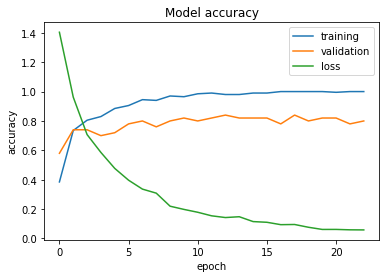

In [27]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()

Nuestra gráfica nos muestra que la pérdida cada vez es menor, con lo cual la precisión es cada vez mejor. Esto último también lo podemos corroborar con su correspondiente función. Vemos que la función de precisión apunta a que al final se clasifican bien casi el 100% de las imágenes de entrenameinto, mientras que las de validación, al ser menos, clasifica bien entre el 80% y 90% (lo podemos ver en la salida del método fit, ejecutado anteriormente).

In [28]:
# Salvado --------------------------------------------------

model.save("mimodelo.h5")

# *Producción*

Ponemos a prueba nuestra red neuronal para varias imágenes de nuestra fuente de dtaos original (no DataGenerator, sino Google Drive).

In [29]:
# Producción ----------------------------------------------

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import keras

model = keras.models.load_model("mimodelo.h5")

%matplotlib inline
pil_im_1 = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/Resized ImageDataGenerator/Validation/Abejas/Abejas45.jpg', 'r')
pil_im_2 = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/Resized ImageDataGenerator/Validation/Aracnidos/Aracnido45.jpg', 'r')
pil_im_3 = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/Resized ImageDataGenerator/Validation/Hormigas/Hormiga45.jpg', 'r')
pil_im_4 = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/Resized ImageDataGenerator/Validation/Libelulas/Libélula45.jpg', 'r')
pil_im_5 = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/Resized ImageDataGenerator/Validation/Saltamontes/Saltamontes45.jpg', 'r')
im1 = np.asarray(pil_im_1.resize((150, 150)))
im2 = np.asarray(pil_im_2.resize((150, 150)))
im3 = np.asarray(pil_im_3.resize((150, 150)))
im4 = np.asarray(pil_im_4.resize((150, 150)))
im5 = np.asarray(pil_im_5.resize((150, 150)))
print(im1.shape) # La imagen es un array de dimensión: 150x150x3


# El método `predict` hace la predicción de un lote de entradas, no solo una. 
# En el caso de que tengamos solo una entrada deberemos añadirle una dimensión más 
# al array numpy para que la entrada tenga la dimensión: 1x150x150x3

(150, 150, 3)



Predicción clase Abejas          1.0000000000
Predicción clase Aracnidos       0.0000000000
Predicción clase Hormigas        0.0000000000
Predicción clase Libelulas       0.0000000000
Predicción clase Saltamontes     0.0000000000

La red neuronal clasifica la imagen como perteneciente a la clase Abejas con una precisión de 1.0000000000



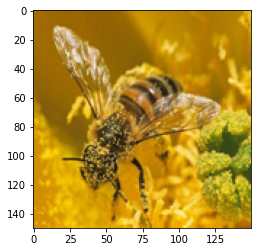

In [30]:
imshow(im1)
im1 = im1.reshape(1,150,150,3)

misClases = validation_generator.class_indices
miPrediccion = model.predict(im1)

print()
for clase in misClases:
  print ("Predicción clase" , f"{clase:15}" , f"{miPrediccion.item(misClases[clase]):>.10f}")

elegida = np.argmax(miPrediccion[0])
claves = list(misClases.keys())

print()
print ("La red neuronal clasifica la imagen como perteneciente a la clase", claves[elegida], "con una precisión de", f"{miPrediccion.item(misClases[claves[elegida]]):>.10f}") 
print() 


Predicción clase Abejas          0.0000000000
Predicción clase Aracnidos       1.0000000000
Predicción clase Hormigas        0.0000000000
Predicción clase Libelulas       0.0000000000
Predicción clase Saltamontes     0.0000000000

La red neuronal clasifica la imagen como perteneciente a la clase Aracnidos con una precisión de 1.0000000000



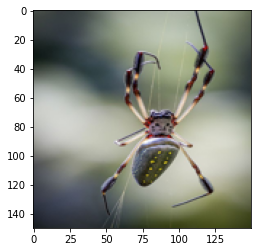

In [31]:
imshow(im2)
im2 = im2.reshape(1,150,150,3)
misClases = validation_generator.class_indices
miPrediccion = model.predict(im2)

for clase in misClases:
  print ("Predicción clase" , f"{clase:15}" , f"{miPrediccion.item(misClases[clase]):.10f}")

elegida = np.argmax(miPrediccion[0])
claves = list(misClases.keys())

print()
print ("La red neuronal clasifica la imagen como perteneciente a la clase", claves[elegida], "con una precisión de", f"{miPrediccion.item(misClases[claves[elegida]]):>.10f}") 
print() 

Predicción clase Abejas          0.0000000000
Predicción clase Aracnidos       0.0000000000
Predicción clase Hormigas        1.0000000000
Predicción clase Libelulas       0.0000000000
Predicción clase Saltamontes     0.0000000000

La red neuronal clasifica la imagen como perteneciente a la clase Hormigas con una precisión de 1.0000000000



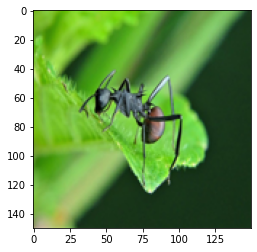

In [32]:
imshow(im3)
im3 = im3.reshape(1,150,150,3)
misClases = validation_generator.class_indices
miPrediccion = model.predict(im3)

for clase in misClases:
  print ("Predicción clase" , f"{clase:15}" , f"{miPrediccion.item(misClases[clase]):.10f}")

elegida = np.argmax(miPrediccion[0])
claves = list(misClases.keys())

print()
print ("La red neuronal clasifica la imagen como perteneciente a la clase", claves[elegida], "con una precisión de", f"{miPrediccion.item(misClases[claves[elegida]]):>.10f}") 
print() 

Predicción clase Abejas          0.0000000000
Predicción clase Aracnidos       0.0000000000
Predicción clase Hormigas        0.0000000000
Predicción clase Libelulas       1.0000000000
Predicción clase Saltamontes     0.0000000000

La red neuronal clasifica la imagen como perteneciente a la clase Libelulas con una precisión de 1.0000000000



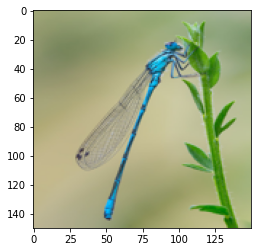

In [33]:
imshow(im4)
im4 = im4.reshape(1,150,150,3)
misClases = validation_generator.class_indices
miPrediccion = model.predict(im4)

for clase in misClases:
  print ("Predicción clase" , f"{clase:15}" , f"{miPrediccion.item(misClases[clase]):.10f}")

elegida = np.argmax(miPrediccion[0])
claves = list(misClases.keys())

print()
print ("La red neuronal clasifica la imagen como perteneciente a la clase", claves[elegida], "con una precisión de", f"{miPrediccion.item(misClases[claves[elegida]]):>.10f}") 
print() 

Predicción clase Abejas          0.0000000000
Predicción clase Aracnidos       0.0000000000
Predicción clase Hormigas        0.0000000000
Predicción clase Libelulas       0.0000000000
Predicción clase Saltamontes     1.0000000000

La red neuronal clasifica la imagen como perteneciente a la clase Saltamontes con una precisión de 1.0000000000



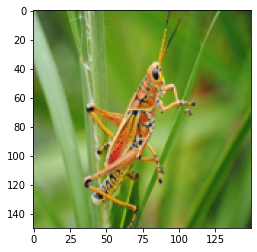

In [34]:
imshow(im5)
im5 = im5.reshape(1,150,150,3)
misClases = validation_generator.class_indices
miPrediccion = model.predict(im5)

for clase in misClases:
  print ("Predicción clase" , f"{clase:15}" , f"{miPrediccion.item(misClases[clase]):.10f}")

elegida = np.argmax(miPrediccion[0])
claves = list(misClases.keys())

print()
print ("La red neuronal clasifica la imagen como perteneciente a la clase", claves[elegida], "con una precisión de", f"{miPrediccion.item(misClases[claves[elegida]]):>.10f}") 
print() 

En general, podemos ver que las imágenes se clasifican muy bien, dando además valores cercanos al 100%, si no dicho valor.

# *Matriz de confusión*

Esta matriz representa la cantidad de imágenes que el modelo clasifica bien, y cuántas confunde con otra clase.

El método confusion_matrix debe recibir dos vectores como parámetros:
*   Vector de valores esperados
*   Vector de valores obtenidos

Como en el dataset de validación tenemos 10 insectos de cada clase, lo ideal sería que en la diagonal principal de la matriz de confusión haya valores cercanos al 10 o directamente un 10, lo cual indicaría que la mayoría o todas las imágenes fueron clasificadas correctamente. Es decir, que la confusión del modelo fue mínima.

Como curiosidad, podemos hacer un informe sobre la clasificación de imágenes con el método classification_report.

La columna **recall** del informe de clasificación nos indica cuántas imágenes fueron clasificadas correctamente en cadad clase.

Por otro lado, la columna **precision** indica la proporción de imágenes correctamente clasificadas en cada clase entre el nº total de imágenes clasificadas en dicha clase.

In [35]:
#Confution Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

print("Valores reales")
print(validation_generator.classes)
print("Valores devueltos")
print(y_pred)
print()
print('Matriz de confusión')
print()
print(confusion_matrix(validation_generator.classes, y_pred))
print()

print('Informe de clasificación')
print()
target_names = ['Abejas', 'Aracnidos', 'Hormigas', 'Libelulas', 'Saltamontes']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Valores reales
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4]
Valores devueltos
[0 0 0 0 0 0 0 0 0 2 2 3 1 1 1 1 3 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 4 3 4 4 3 4 4 4 4 4 4 3 4]

Matriz de confusión

[[ 9  0  1  0  0]
 [ 0  7  1  2  0]
 [ 0  0 10  0  0]
 [ 0  0  0  8  2]
 [ 0  0  0  2  8]]

Informe de clasificación

              precision    recall  f1-score   support

      Abejas       1.00      0.90      0.95        10
   Aracnidos       1.00      0.70      0.82        10
    Hormigas       0.83      1.00      0.91        10
   Libelulas       0.67      0.80      0.73        10
 Saltamontes       0.80      0.80      0.80        10

    accuracy                           0.84        50
   macro avg       0.86      0.84      0.84        50
weighted avg       0.86      0.84      0.84        50



# *Matriz de confusión validando imágenes de la fuente de datos original (Google Drive)*

Creamos también la matriz de confusión resultante de intentar clasificar las imágenes del conjunto de validación desde su fuente de datos original.

Para ello, tendremos que recorrer cada una de las carpetas correspondientes a cada clase y aplicar el método "predict" sobre cada imagen, rellenando progresivamente el vector de valores obtenidos (de la predicción) con la clase con mayor porcentaje de acierto en cada imagen. Dicho vector junto al de valores esperados serán los pasados a la función "confusion_matrix". Los resultados no deberán diferir demasiado de los de la matriz de confusión obtenida en el punto anterior.

In [36]:
lista = []

for i in range(41,51):
  pil_im_x = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/Resized ImageDataGenerator/Validation/Abejas/Abejas' + str(i) + '.jpg', 'r')
  imx = np.asarray(pil_im_x.resize((150, 150)))
  imx = imx.reshape(1,150,150,3)
  miPrediccion = model.predict(imx)
  elegida = np.argmax(miPrediccion[0])
  lista.append(elegida)

for i in range(41,51):
  pil_im_x = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/Resized ImageDataGenerator/Validation/Aracnidos/Aracnido' + str(i) + '.jpg', 'r')
  imx = np.asarray(pil_im_x.resize((150, 150)))
  imx = imx.reshape(1,150,150,3)
  miPrediccion = model.predict(imx)
  elegida = np.argmax(miPrediccion[0])
  lista.append(elegida)

for i in range(41,51):
  pil_im_x = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/Resized ImageDataGenerator/Validation/Hormigas/Hormiga' + str(i) + '.jpg', 'r')
  imx = np.asarray(pil_im_x.resize((150, 150)))
  imx = imx.reshape(1,150,150,3)
  miPrediccion = model.predict(imx)
  elegida = np.argmax(miPrediccion[0])
  lista.append(elegida)

for i in range(41,51):
  pil_im_x = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/Resized ImageDataGenerator/Validation/Libelulas/Libélula' + str(i) + '.jpg', 'r')
  imx = np.asarray(pil_im_x.resize((150, 150)))
  imx = imx.reshape(1,150,150,3)
  miPrediccion = model.predict(imx)
  elegida = np.argmax(miPrediccion[0])
  lista.append(elegida)

for i in range(41,51):
  pil_im_x = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/Resized ImageDataGenerator/Validation/Saltamontes/Saltamontes' + str(i) + '.jpg', 'r')
  imx = np.asarray(pil_im_x.resize((150, 150)))
  imx = imx.reshape(1,150,150,3)
  miPrediccion = model.predict(imx)
  elegida = np.argmax(miPrediccion[0])
  lista.append(elegida)

print("Valores reales")
print(validation_generator.classes)
print("Valores devueltos")
print(lista)
print()

print('Matriz de confusión')
print()
print(confusion_matrix(validation_generator.classes, lista))
print()

print('Informe de clasificación')
print()
target_names = ['Abejas', 'Aracnidos', 'Hormigas', 'Libelulas', 'Saltamontes']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Valores reales
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4]
Valores devueltos
[2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 3, 1, 1, 1, 1, 3, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4]

Matriz de confusión

[[8 0 1 0 1]
 [0 7 1 2 0]
 [0 1 9 0 0]
 [0 0 0 8 2]
 [0 0 0 1 9]]

Informe de clasificación

              precision    recall  f1-score   support

      Abejas       1.00      0.90      0.95        10
   Aracnidos       1.00      0.70      0.82        10
    Hormigas       0.83      1.00      0.91        10
   Libelulas       0.67      0.80      0.73        10
 Saltamontes       0.80      0.80      0.80        10

    accuracy                           0.84        50
   macro avg       0.86      0.84      0.84        50
weighted avg       0.86      0.84      0.84        50

